# Description - Predictive Power at the Segment Level for PSDsleep and GSamplitude

This notebook generates Figure 11

# Import Libraries

In [1]:
import pandas as pd
import numpy  as np
import xarray as xr
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import os.path as osp
from utils.basics import get_available_runs
from utils.variables import DATA_DIR, Resources_Dir

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import sklearn 

print('pandas: %s' % str(pd.__version__))
print('sklearn: %s' % str(sklearn.__version__))
print('seaborn: %s' % str(sns.__version__))
%matplotlib inline

pandas: 1.3.1
sklearn: 0.24.2
seaborn: 0.11.1


# Configuration Variables

In [2]:
k_folds            = 20
spectrogram_windur = 60 # In seconds
region             = 'V4lt_grp'

# Load Lists of Scans (all, awake, drowsy)

In [3]:
%%time
scan_HR_info    = pd.read_csv(osp.join(Resources_Dir,'HR_scaninfo.csv'), index_col=0)
scan_HR_info    = scan_HR_info[(scan_HR_info['HR aliased']< 0.03) | (scan_HR_info['HR aliased']> 0.07)]
Manuscript_Runs = list(scan_HR_info.index)
Awake_Runs      = list(scan_HR_info[scan_HR_info['Scan Type']=='Awake'].index)
Drowsy_Runs     = list(scan_HR_info[scan_HR_info['Scan Type']=='Drowsy'].index)

print('++ INFO: Number of Runs: Total = %d | Awake = %d | Drowsy = %d' % (len(Manuscript_Runs), len(Awake_Runs), len(Drowsy_Runs)))

++ INFO: Number of Runs: Total = 366 | Awake = 192 | Drowsy = 174
CPU times: user 2.97 ms, sys: 2.29 ms, total: 5.27 ms
Wall time: 5 ms


# Load Pre-processed ET Data and Downsample it to 1Hz (to match fMRI data)

In [4]:
ET_PupilSize_Proc_1Hz = pd.read_pickle(osp.join(Resources_Dir,'ET_PupilSize_Proc_1Hz_corrected.pkl'))

In [5]:
[Nacq, Nruns ]              =  ET_PupilSize_Proc_1Hz.shape
print('++ Number of acquisitions = %d' % Nacq)
print('++ Number of runs = %d' % Nruns)

++ Number of acquisitions = 890
++ Number of runs = 561


In [6]:
ET_PupilSize_Proc_1Hz = ET_PupilSize_Proc_1Hz[Manuscript_Runs]
print('++ INFO: Shape of Pupil Size Dataframe [ET_PupilSize_Proc_1Hz] is %s' % str(ET_PupilSize_Proc_1Hz.shape))

++ INFO: Shape of Pupil Size Dataframe [ET_PupilSize_Proc_1Hz] is (890, 366)


In [7]:
EC_Windowed = ET_PupilSize_Proc_1Hz.isna().rolling(window=spectrogram_windur, center=True).sum().dropna()
EC_Windowed = 100*(EC_Windowed/spectrogram_windur)

In [8]:
def assign_labels(a):
    if a >= 60:
        return 'EC/Drowsy'
    if a <= 40:
        return 'EO/Awake'
    return 'Mixed'

In [9]:
EC_Windowed_Labels = EC_Windowed.applymap(assign_labels)

# Load PSD in Sleep Band

This data is already the result of a windowing operation (computation of the spectrogram). As such, we ensure the index has the correct values corresponding to windowed information

In [10]:
# Infer how the index should look for a spectrogram computed with a given window duration
time_index         = pd.timedelta_range(start='0 s', periods=Nacq, freq='s')
# Create empty dataframe with index having time_delta in steps of seconds
aux = pd.DataFrame(np.ones(Nacq),index=time_index)
# Simulate rolling windows of spectrogram_windur to gather which index should have data
aux                    = aux.rolling(window=spectrogram_windur, center=True).mean()
aux                    = aux.dropna()
windowed_time_index    = aux.index
del aux

In [11]:
%%time
PSD_Windowed     = pd.DataFrame(index=windowed_time_index, columns=Manuscript_Runs)
for sbj_run in Manuscript_Runs:
    sbj,run = sbj_run.split('_',1)
    file    = '{RUN}_mPP.Signal.{REGION}.Spectrogram_BandLimited.pkl'.format(RUN=run, REGION=region)
    path    = osp.join(DATA_DIR,sbj,run,file)
    aux     = pd.read_pickle(path)
    PSD_Windowed.loc[(windowed_time_index,sbj_run)] = aux['sleep'].values

CPU times: user 288 ms, sys: 38.6 ms, total: 327 ms
Wall time: 363 ms


In [12]:
PSD_Windowed.head()

,100610_rfMRI_REST3_PA,100610_rfMRI_REST4_AP,104416_rfMRI_REST3_PA,105923_rfMRI_REST3_PA,105923_rfMRI_REST4_AP,111312_rfMRI_REST1_PA,111312_rfMRI_REST3_PA,114823_rfMRI_REST2_AP,114823_rfMRI_REST4_AP,115017_rfMRI_REST4_AP,...,942658_rfMRI_REST4_AP,943862_rfMRI_REST1_PA,943862_rfMRI_REST3_PA,958976_rfMRI_REST1_PA,958976_rfMRI_REST3_PA,966975_rfMRI_REST2_AP,966975_rfMRI_REST3_PA,966975_rfMRI_REST4_AP,971160_rfMRI_REST2_AP,995174_rfMRI_REST3_PA
0 days 00:00:30,2.549136,15.06842,1.117133,25.6156,12.842756,8.638944,14.901316,12.340505,1.172426,2.947821,...,6.273698,42.254131,38.955629,0.515301,2.090623,17.764591,23.68478,51.045559,0.991968,0.688141
0 days 00:00:31,2.363269,13.413667,1.162641,24.257549,12.182682,8.466334,14.124565,11.599217,1.192902,2.409055,...,5.273722,43.821136,36.681123,0.675181,2.178683,17.100493,25.883256,50.571614,1.029551,0.748103
0 days 00:00:32,2.209525,11.327775,1.199198,22.555677,10.924166,8.131935,13.386574,11.174929,1.227875,2.039676,...,4.359094,46.935463,35.245071,0.812344,2.265799,16.402025,29.529777,50.031299,1.091669,1.001462
0 days 00:00:33,2.08291,8.962747,1.238974,20.704385,9.344547,7.704778,12.943813,10.902662,1.23393,2.019673,...,3.771409,51.317898,34.501648,0.873003,2.274345,15.361872,34.191784,49.891527,1.13791,1.420147
0 days 00:00:34,1.970267,6.849076,1.325144,18.828783,7.7797,7.345057,12.940821,10.638341,1.180362,2.038604,...,3.587751,56.288946,34.320736,0.876964,2.233439,14.24667,39.003926,49.900917,1.163724,1.852698


# Load Global Signal

In [13]:
GS_df = pd.DataFrame(columns=Manuscript_Runs)
for item in Manuscript_Runs:
    sbj,run  = item.split('_',1)
    aux_path = osp.join(DATA_DIR,sbj,run,'{RUN}_mPP.Signal.FB.1D'.format(RUN=run))
    if not osp.exists(aux_path):
        print(' + --> WARNING: Missing file: %s' % aux_path)
        continue
    aux_data = np.loadtxt(aux_path)
    assert aux_data.shape[0] == Nacq, "{file} has incorrect length {length}".format(file=aux_path, length=str(aux_data.shape[0]))
    GS_df[item] = aux_data
print(' + INFO: df.shape = %s' % str(GS_df.shape))  

 + INFO: df.shape = (890, 366)


In [ ]:
GS_Windowed = GS_df.rolling(window=spectrogram_windur, center=True).std().dropna()
GS_Windowed.index = PSD_Windowed.index

In [ ]:
GS_Windowed.head()

# Generate Classification Problem

In [ ]:
data = pd.DataFrame()
data['PSDsleep']    = PSD_Windowed.melt()['value']
data['GSamplitude'] = GS_Windowed.melt()['value']
data['EC']          = EC_Windowed.melt()['value']
data['Label']       = EC_Windowed_Labels.melt()['value']
print(data.shape)

In [17]:
data = data[(data['Label']=='EO/Awake') | (data['Label']=='EC/Drowsy')]
data = data.reset_index(drop=True)
print(data.shape)

(281648, 4)


# Logistic Regression (Stratified k-Cross Validation)

I think this will make things better because our sample is very much unbalanced

In [18]:
num_awake_umbalanced  = (data['Label']=='EO/Awake').sum()
num_drowsy_umbalanced = (data['Label']=='EC/Drowsy').sum()
num_mixed_umbalanced = (data['Label']=='Mixed').sum()
num_total_umbalanced  = data.shape[0]
print("++ INFO: Number of Awake Samples:  %d/%d [%.2f]" % (num_awake_umbalanced, num_total_umbalanced,100*num_awake_umbalanced/num_total_umbalanced))
print("++ INFO: Number of Drowsy Samples: %d/%d [%.2f]" % (num_drowsy_umbalanced,num_total_umbalanced,100*num_drowsy_umbalanced/num_total_umbalanced))
print("++ INFO: Number of Mixed Samples: %d/%d [%.2f]" % (num_mixed_umbalanced,num_total_umbalanced,100*num_mixed_umbalanced/num_total_umbalanced))

++ INFO: Number of Awake Samples:  212158/281648 [75.33]
++ INFO: Number of Drowsy Samples: 69490/281648 [24.67]
++ INFO: Number of Mixed Samples: 0/281648 [0.00]


In [19]:
skf_umbalanced = StratifiedKFold(n_splits=k_folds, shuffle=True)

## Training / Testing in umbalanced sample

In [20]:
data_umbalanced = data.copy()

In [21]:
%%time
input_features         = ['PSDsleep','GSamplitude','Control','PSD & GS']
scores_umbalanced      = pd.DataFrame(index=np.arange(k_folds))
predictions_umbalanced = {}
true_vals_umbalanced   = {}
conf_mat_umbalanced    = xr.DataArray(dims=['Metric','K-Fold','True Label','Predicted Label'],
                                      coords={'Metric':input_features,
                                              'K-Fold':np.arange(k_folds),
                                              'True Label':['EC/Drowsy','EO/Awake'],
                                              'Predicted Label':['EC/Drowsy','EO/Awake']})
for metric in input_features:
    print('++ Working on %s ...' % metric)
    if metric == 'Control':
        X_aux = data_umbalanced['PSDsleep'].values.reshape(-1, 1)
        y_aux = data_umbalanced['Label']
        X,y = shuffle(X_aux,y_aux)
    if metric == 'PSDsleep':
        X = data_umbalanced['PSDsleep'].values.reshape(-1, 1)
        y = data_umbalanced['Label']
    if metric == 'GSamplitude':
        X = data_umbalanced['GSamplitude'].values.reshape(-1, 1)
        y = data_umbalanced['Label']
    if metric == 'PSD & GS':
        X = data_umbalanced[['PSDsleep','GSamplitude']].values
        y = data_umbalanced['Label']
    aux_num_awake  = (y=='EO/Awake').sum()
    aux_num_drowsy = (y=='EC/Drowsy').sum()
    aux_num_total  = y.shape[0]
    print(" + INFO: Number of Awake Samples:  %d/%d [%.2f]" % (aux_num_awake, aux_num_total,100*aux_num_awake/aux_num_total))
    print(" + INFO: Number of Drowsy Samples: %d/%d [%.2f]" % (aux_num_drowsy,aux_num_total,100*aux_num_drowsy/aux_num_total))
    for i, (train_index, test_index) in enumerate(skf_umbalanced.split(X, y)):
        log_reg = LogisticRegression(random_state=42, fit_intercept=True, max_iter=5000, n_jobs=-1, class_weight='balanced')
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        aux_num_awake_train  = (y_train=='EO/Awake').sum()
        aux_num_drowsy_train = (y_train=='EC/Drowsy').sum()
        aux_num_total_train = y_train.shape[0]
        aux_num_awake_test  = (y_test=='EO/Awake').sum()
        aux_num_drowsy_test = (y_test=='EC/Drowsy').sum()
        aux_num_total_test = y_test.shape[0]
        print(' + --> Split [%d - Training Set]: Awake [%d/%d [%.2f]] | Drowsy [%d/%d [%.2f]]' % (i,aux_num_awake_train, aux_num_total_train,100*aux_num_awake_train/aux_num_total_train,
                                                                                                                         aux_num_drowsy_train,aux_num_total_train,100*aux_num_drowsy_train/aux_num_total_train))
        print(' + --> Split [%d - Test Set    ]: Awake [%d/%d [%.2f]] | Drowsy [%d/%d [%.2f]]' % (i,aux_num_awake_test , aux_num_total_test ,100*aux_num_awake_test/aux_num_total_test,
                                                                                                                         aux_num_drowsy_test ,aux_num_total_test ,100*aux_num_drowsy_test/aux_num_total_test))
        
        log_reg.fit(X_train,y_train)
        scores_umbalanced.loc[i,metric]    = log_reg.score(X_test,y_test)
        predictions_umbalanced[(metric,i)] = log_reg.predict(X_test)
        true_vals_umbalanced[(metric,i)]   = y_test 
        conf_mat_umbalanced.loc[metric,i,:,:]  = confusion_matrix(true_vals_umbalanced[(metric,i)],predictions_umbalanced[(metric,i)], normalize='pred') #Precision

scores_umbalanced = scores_umbalanced.infer_objects()

++ Working on PSDsleep ...
 + INFO: Number of Awake Samples:  212158/281648 [75.33]
 + INFO: Number of Drowsy Samples: 69490/281648 [24.67]
 + --> Split [0 - Training Set]: Awake [201550/267565 [75.33]] | Drowsy [66015/267565 [24.67]]
 + --> Split [0 - Test Set    ]: Awake [10608/14083 [75.32]] | Drowsy [3475/14083 [24.68]]
 + --> Split [1 - Training Set]: Awake [201550/267565 [75.33]] | Drowsy [66015/267565 [24.67]]
 + --> Split [1 - Test Set    ]: Awake [10608/14083 [75.32]] | Drowsy [3475/14083 [24.68]]
 + --> Split [2 - Training Set]: Awake [201550/267565 [75.33]] | Drowsy [66015/267565 [24.67]]
 + --> Split [2 - Test Set    ]: Awake [10608/14083 [75.32]] | Drowsy [3475/14083 [24.68]]
 + --> Split [3 - Training Set]: Awake [201550/267565 [75.33]] | Drowsy [66015/267565 [24.67]]
 + --> Split [3 - Test Set    ]: Awake [10608/14083 [75.32]] | Drowsy [3475/14083 [24.68]]
 + --> Split [4 - Training Set]: Awake [201550/267565 [75.33]] | Drowsy [66015/267565 [24.67]]
 + --> Split [4 - Tes

Statistical Test for Umbalanced/Original Sample Scenario
PSD vs. Control:  Ttest_indResult(statistic=11.015059420384484, pvalue=2.173556745227076e-13)
GS vs. Control:   Ttest_indResult(statistic=11.133336197679448, pvalue=1.590662750634755e-13)
GS+ vs. Control:   Ttest_indResult(statistic=11.33626988318219, pvalue=9.348853845443229e-14)
-----
PSD vs. GS:   Ttest_indResult(statistic=-3.864660782695685, pvalue=0.0004210129323216274)
GS+ vs. GS:   Ttest_indResult(statistic=6.876084823484989, pvalue=3.6196663462841935e-08)
GS+ vs. GS:   Ttest_indResult(statistic=9.405255495091597, pvalue=1.824308660659524e-11)


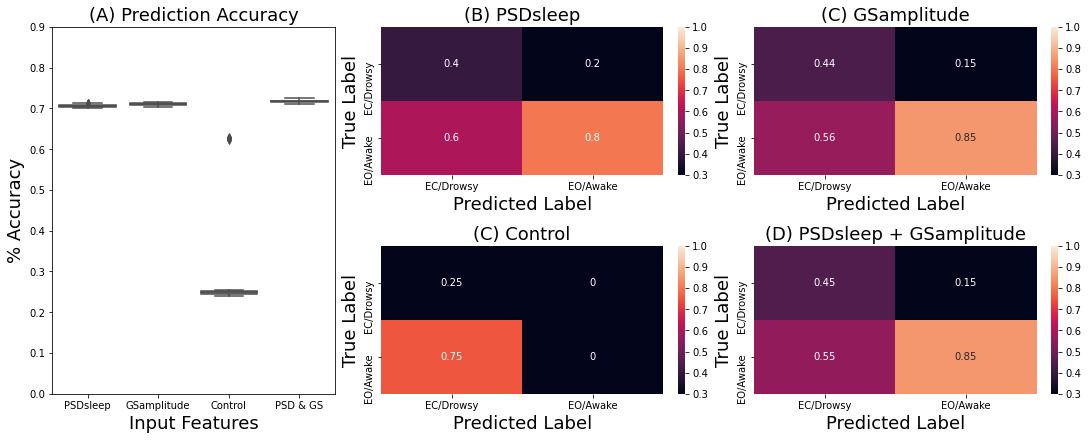

In [22]:
fig_umbal = plt.figure(constrained_layout=True, figsize=(15,6))
gs = fig_umbal.add_gridspec(2, 3)
fig_umbal_box    = fig_umbal.add_subplot(gs[:, 0])
fig_umbal_cm_psd = fig_umbal.add_subplot(gs[0, 1])
fig_umbal_cm_gs  = fig_umbal.add_subplot(gs[0, 2])
fig_umbal_cm_rnd = fig_umbal.add_subplot(gs[1, 1])
fig_umbal_cm_pgs = fig_umbal.add_subplot(gs[1, 2])

umbal_boxplot = sns.boxplot(data=scores_umbalanced, ax=fig_umbal_box, color='grey')
umbal_boxplot.set_title('(A) Prediction Accuracy', fontsize=18)
umbal_boxplot.set_xlabel('Input Features', fontsize=18)
umbal_boxplot.set_ylabel('% Accuracy', fontsize=18)
umbal_boxplot.set_ylim(0,0.9)
cm_umbal_psd       = pd.DataFrame(conf_mat_umbalanced.median(axis=1).loc['PSDsleep'].values, columns=['EC/Drowsy','EO/Awake'], index=['EC/Drowsy','EO/Awake'])
cm_umbal_psd_plot  = sns.heatmap(data=cm_umbal_psd,cmap='rocket',annot=True, vmin=0.3, vmax=1, ax=fig_umbal_cm_psd)
cm_umbal_psd_plot.set_xlabel('Predicted Label', fontsize=18)
cm_umbal_psd_plot.set_ylabel('True Label', fontsize=18)
cm_umbal_psd_plot.set_title('(B) PSDsleep', fontsize=18)

cm_umbal_gs        = pd.DataFrame(conf_mat_umbalanced.median(axis=1).loc['GSamplitude'].values, columns=['EC/Drowsy','EO/Awake'], index=['EC/Drowsy','EO/Awake'])
cm_umbal_gs_plot   = sns.heatmap(data=cm_umbal_gs,cmap='rocket',annot=True, vmin=0.3, vmax=1, ax=fig_umbal_cm_gs)
cm_umbal_gs_plot.set_xlabel('Predicted Label', fontsize=18)
cm_umbal_gs_plot.set_ylabel('True Label', fontsize=18)
cm_umbal_gs_plot.set_title('(C) GSamplitude', fontsize=18)

cm_umbal_rand      = pd.DataFrame(conf_mat_umbalanced.median(axis=1).loc['Control'].values, columns=['EC/Drowsy','EO/Awake'], index=['EC/Drowsy','EO/Awake'])
cm_umbal_rand_plot = sns.heatmap(data=cm_umbal_rand,cmap='rocket',annot=True, vmin=0.3, vmax=1, ax=fig_umbal_cm_rnd)
cm_umbal_rand_plot.set_xlabel('Predicted Label', fontsize=18)
cm_umbal_rand_plot.set_ylabel('True Label', fontsize=18)
cm_umbal_rand_plot.set_title('(C) Control', fontsize=18)

cm_umbal_pgs      = pd.DataFrame(conf_mat_umbalanced.median(axis=1).loc['PSD & GS'].values, columns=['EC/Drowsy','EO/Awake'], index=['EC/Drowsy','EO/Awake'])
cm_umbal_pgs_plot = sns.heatmap(data=cm_umbal_pgs,cmap='rocket',annot=True, vmin=0.3, vmax=1, ax=fig_umbal_cm_pgs)
cm_umbal_pgs_plot.set_xlabel('Predicted Label', fontsize=18)
cm_umbal_pgs_plot.set_ylabel('True Label', fontsize=18)
cm_umbal_pgs_plot.set_title('(D) PSDsleep + GSamplitude', fontsize=18)

print('Statistical Test for Umbalanced/Original Sample Scenario')
print('========================================================')
print('PSD vs. Control:  %s' % str(ttest_ind(scores_umbalanced['PSDsleep'],scores_umbalanced['Control'], alternative='two-sided')))
print('GS vs. Control:   %s' % str(ttest_ind(scores_umbalanced['GSamplitude'],scores_umbalanced['Control'], alternative='two-sided')))
print('GS+ vs. Control:   %s' % str(ttest_ind(scores_umbalanced['PSD & GS'],scores_umbalanced['Control'], alternative='two-sided')))
print('-----')
print('PSD vs. GS:   %s' % str(ttest_ind(scores_umbalanced['PSDsleep'],scores_umbalanced['GSamplitude'], alternative='two-sided')))
print('GS+ vs. GS:   %s' % str(ttest_ind(scores_umbalanced['PSD & GS'],scores_umbalanced['GSamplitude'], alternative='two-sided')))
print('GS+ vs. GS:   %s' % str(ttest_ind(scores_umbalanced['PSD & GS'],scores_umbalanced['PSDsleep'], alternative='two-sided')))

In [23]:
fig_umbal.savefig('./figures/Fig11_LogisticRegression.{region}.noHRa.png'.format(region=region))

## Testing/Training Balanced Sample (Not reported)

In [24]:
min_num_samples = np.min([num_drowsy_umbalanced,num_awake_umbalanced])
data_balanced = pd.concat([data[data['Label']=='EC/Drowsy'].sample(min_num_samples), 
                           data[data['Label']=='EO/Awake'].sample(min_num_samples)], axis=0).reset_index(drop=True)

In [25]:
num_awake_bal  = (data_balanced['Label']=='EO/Awake').sum()
num_drowsy_bal = (data_balanced['Label']=='EO/Awake').sum()
num_total_bal  = data_balanced.shape[0]
print("++ INFO: Number of Awake Samples :  %d/%d [%.2f]" % (num_awake_bal, num_total_bal,100*num_awake_bal/num_total_bal))
print("++ INFO: Number of Drowsy Samples: %d/%d [%.2f]" % (num_drowsy_bal,num_total_bal,100*num_drowsy_bal/num_total_bal))

++ INFO: Number of Awake Samples :  69490/138980 [50.00]
++ INFO: Number of Drowsy Samples: 69490/138980 [50.00]


In [26]:
skf_balanced = StratifiedKFold(n_splits=k_folds, shuffle=True)

In [27]:
%%time
input_features       = ['PSDsleep','GSamplitude','Control','PSD & GS']
scores_balanced      = pd.DataFrame(index=np.arange(k_folds))
predictions_balanced = {}
true_vals_balanced   = {}
conf_mat_balanced    = xr.DataArray(dims=['Metric','K-Fold','True Label','Predicted Label'],
                                      coords={'Metric':input_features,
                                              'K-Fold':np.arange(k_folds),
                                              'True Label':['EC/Drowsy','EO/Awake'],
                                              'Predicted Label':['EC/Drowsy','EO/Awake']})
for metric in input_features:
    print('++ Working on %s ...' % metric)
    if metric == 'Control':
        X_aux = data_balanced['PSDsleep'].values.reshape(-1, 1)
        y_aux = data_balanced['Label']
        X,y = shuffle(X_aux,y_aux)
    if metric == 'PSDsleep':
        X = data_balanced['PSDsleep'].values.reshape(-1, 1)
        y = data_balanced['Label']
    if metric == 'GSamplitude':
        X = data_balanced['GSamplitude'].values.reshape(-1, 1)
        y = data_balanced['Label']
    if metric == 'PSD & GS':
        X = data_balanced[['PSDsleep','GSamplitude']].values
        y = data_balanced['Label']
    aux_num_awake  = (y=='EO/Awake').sum()
    aux_num_drowsy = (y=='EC/Drowsy').sum()
    aux_num_total  = y.shape[0]
    print(" + INFO: Number of Awake Samples : %d/%d [%.2f]" % (aux_num_awake, aux_num_total,100*aux_num_awake/aux_num_total))
    print(" + INFO: Number of Drowsy Samples: %d/%d [%.2f]" % (aux_num_drowsy,aux_num_total,100*aux_num_drowsy/aux_num_total))
    for i, (train_index, test_index) in enumerate(skf_balanced.split(X, y)):
        log_reg = LogisticRegression(random_state=42, fit_intercept=True, max_iter=5000, n_jobs=-1)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        aux_num_awake_train  = (y_train=='EO/Awake').sum()
        aux_num_drowsy_train = (y_train=='EC/Drowsy').sum()
        aux_num_total_train = y_train.shape[0]
        aux_num_awake_test  = (y_test=='EO/Awake').sum()
        aux_num_drowsy_test = (y_test=='EC/Drowsy').sum()
        aux_num_total_test = y_test.shape[0]
        print(' + --> Split [%d - Training Set]: Awake [%d/%d [%.2f]] | Drowsy [%d/%d [%.2f]]' % (i,aux_num_awake_train, aux_num_total_train,100*aux_num_awake_train/aux_num_total_train,
                                                                                                                         aux_num_drowsy_train,aux_num_total_train,100*aux_num_drowsy_train/aux_num_total_train))
        print(' + --> Split [%d - Test Set    ]: Awake [%d/%d [%.2f]] | Drowsy [%d/%d [%.2f]]' % (i,aux_num_awake_test , aux_num_total_test ,100*aux_num_awake_test/aux_num_total_test,
                                                                                                                         aux_num_drowsy_test ,aux_num_total_test ,100*aux_num_drowsy_test/aux_num_total_test))
        
        log_reg.fit(X_train,y_train)
        scores_balanced.loc[i,metric]    = log_reg.score(X_test,y_test)
        predictions_balanced[(metric,i)] = log_reg.predict(X_test)
        true_vals_balanced[(metric,i)]   = y_test 
        conf_mat_balanced.loc[metric,i,:,:]  = confusion_matrix(true_vals_balanced[(metric,i)],predictions_balanced[(metric,i)], normalize='pred') #PRECISION
scores_balanced = scores_balanced.infer_objects()

++ Working on PSDsleep ...
 + INFO: Number of Awake Samples : 69490/138980 [50.00]
 + INFO: Number of Drowsy Samples: 69490/138980 [50.00]
 + --> Split [0 - Training Set]: Awake [66016/132031 [50.00]] | Drowsy [66015/132031 [50.00]]
 + --> Split [0 - Test Set    ]: Awake [3474/6949 [49.99]] | Drowsy [3475/6949 [50.01]]
 + --> Split [1 - Training Set]: Awake [66016/132031 [50.00]] | Drowsy [66015/132031 [50.00]]
 + --> Split [1 - Test Set    ]: Awake [3474/6949 [49.99]] | Drowsy [3475/6949 [50.01]]
 + --> Split [2 - Training Set]: Awake [66016/132031 [50.00]] | Drowsy [66015/132031 [50.00]]
 + --> Split [2 - Test Set    ]: Awake [3474/6949 [49.99]] | Drowsy [3475/6949 [50.01]]
 + --> Split [3 - Training Set]: Awake [66016/132031 [50.00]] | Drowsy [66015/132031 [50.00]]
 + --> Split [3 - Test Set    ]: Awake [3474/6949 [49.99]] | Drowsy [3475/6949 [50.01]]
 + --> Split [4 - Training Set]: Awake [66016/132031 [50.00]] | Drowsy [66015/132031 [50.00]]
 + --> Split [4 - Test Set    ]: Awake 

Text(0.5, 1.0, '(D) PSDsleep + GSamplitude')

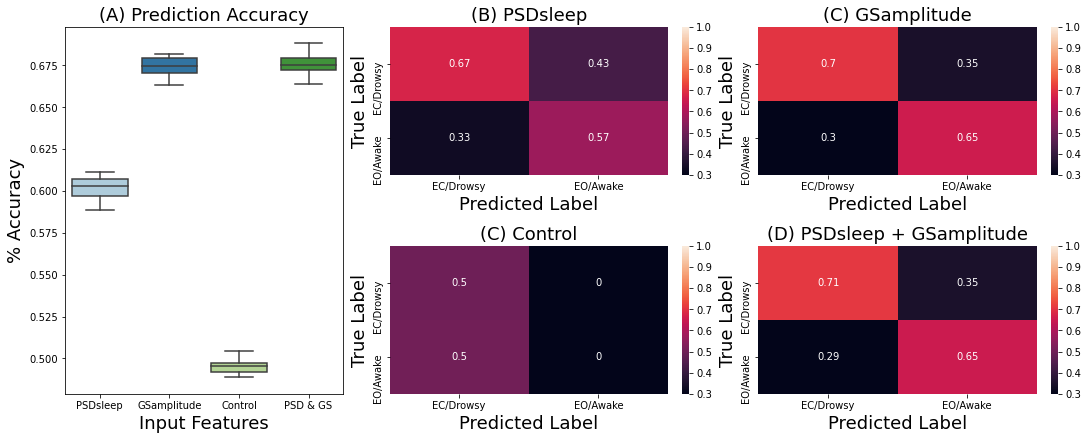

In [28]:
fig_bal = plt.figure(constrained_layout=True, figsize=(15,6))
gs = fig_bal.add_gridspec(2, 3)
fig_bal_box    = fig_bal.add_subplot(gs[:, 0])
fig_bal_cm_psd = fig_bal.add_subplot(gs[0, 1])
fig_bal_cm_gs  = fig_bal.add_subplot(gs[0, 2])
fig_bal_cm_rnd = fig_bal.add_subplot(gs[1, 1])
fig_bal_cm_pgs = fig_bal.add_subplot(gs[1, 2])

bal_boxplot = sns.boxplot(data=scores_balanced, ax=fig_bal_box, palette=sns.color_palette("Paired", 4))
bal_boxplot.set_title('(A) Prediction Accuracy', fontsize=18)
bal_boxplot.set_xlabel('Input Features', fontsize=18)
bal_boxplot.set_ylabel('% Accuracy', fontsize=18)

cm_bal_psd       = pd.DataFrame(conf_mat_balanced.median(axis=1).loc['PSDsleep'].values, columns=['EC/Drowsy','EO/Awake'], index=['EC/Drowsy','EO/Awake'])
cm_bal_psd_plot  = sns.heatmap(data=cm_bal_psd,cmap='rocket',annot=True, vmin=0.3, vmax=1, ax=fig_bal_cm_psd)
cm_bal_psd_plot.set_xlabel('Predicted Label', fontsize=18)
cm_bal_psd_plot.set_ylabel('True Label', fontsize=18)
cm_bal_psd_plot.set_title('(B) PSDsleep', fontsize=18)

cm_bal_gs        = pd.DataFrame(conf_mat_balanced.median(axis=1).loc['GSamplitude'].values, columns=['EC/Drowsy','EO/Awake'], index=['EC/Drowsy','EO/Awake'])
cm_bal_gs_plot   = sns.heatmap(data=cm_bal_gs,cmap='rocket',annot=True, vmin=0.3, vmax=1, ax=fig_bal_cm_gs)
cm_bal_gs_plot.set_xlabel('Predicted Label', fontsize=18)
cm_bal_gs_plot.set_ylabel('True Label', fontsize=18)
cm_bal_gs_plot.set_title('(C) GSamplitude', fontsize=18)

cm_bal_rand      = pd.DataFrame(conf_mat_balanced.median(axis=1).loc['Control'].values, columns=['EC/Drowsy','EO/Awake'], index=['EC/Drowsy','EO/Awake'])
cm_bal_rand_plot = sns.heatmap(data=cm_bal_rand,cmap='rocket',annot=True, vmin=0.3, vmax=1, ax=fig_bal_cm_rnd)
cm_bal_rand_plot.set_xlabel('Predicted Label', fontsize=18)
cm_bal_rand_plot.set_ylabel('True Label', fontsize=18)
cm_bal_rand_plot.set_title('(C) Control', fontsize=18)

cm_bal_pgs      = pd.DataFrame(conf_mat_balanced.median(axis=1).loc['PSD & GS'].values, columns=['EC/Drowsy','EO/Awake'], index=['EC/Drowsy','EO/Awake'])
cm_bal_pgs_plot = sns.heatmap(data=cm_bal_pgs,cmap='rocket',annot=True, vmin=0.3, vmax=1, ax=fig_bal_cm_pgs)
cm_bal_pgs_plot.set_xlabel('Predicted Label', fontsize=18)
cm_bal_pgs_plot.set_ylabel('True Label', fontsize=18)
cm_bal_pgs_plot.set_title('(D) PSDsleep + GSamplitude', fontsize=18)

In [29]:
print('Statistical Test for Balanced Sample Scenario')
print('===============================================')
print('PSD vs. Control:  %s' % str(ttest_ind(scores_balanced['PSDsleep'],scores_balanced['Control'], alternative='two-sided')))
print('GS vs. Control:   %s' % str(ttest_ind(scores_balanced['GSamplitude'],scores_balanced['Control'], alternative='two-sided')))
print('PSD vs. GS:   %s' % str(ttest_ind(scores_balanced['PSDsleep'],scores_balanced['GSamplitude'], alternative='two-sided')))
print('GS+ vs. GS:   %s' % str(ttest_ind(scores_balanced['PSD & GS'],scores_balanced['GSamplitude'], alternative='two-sided')))

Statistical Test for Balanced Sample Scenario
PSD vs. Control:  Ttest_indResult(statistic=59.691886042772325, pvalue=3.588809587749041e-39)
GS vs. Control:   Ttest_indResult(statistic=116.55667756136523, pvalue=3.7514179911881344e-50)
PSD vs. GS:   Ttest_indResult(statistic=-37.28930519004274, pvalue=1.5415516574141203e-31)
GS+ vs. GS:   Ttest_indResult(statistic=0.6324326483715421, pvalue=0.5308914529598905)
